In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import phate

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

from External.ICT.calculate_ICT import calculate_ICT
from External.clustering import centers, k_means_pp, ICT_clusters, cfilter, cassign
from External.generation import create_graph, load_image, sample_points_from_image, find_backbone
from External.plotting import plot_points, plot_graph, no_intersections
from External.reweight import reweight_clusters
from External.data_loader import data_loader

from copy import deepcopy

# from External.create_k_nearest import patch_together

plt.style.use('standard.mplstyle')

In [5]:
# Hyperparameters
mode = "K_Nearest+Density2" # Graph construction mode
ICT_algorithm = "cluster_all"
metric = "euclidean" # metric for clustering
Random = False
image_name = "image"

# Cluster rassignment
min_cluster_size = 12
small_behavior = "reassign" #reassign or remove

In [6]:
# 2D Phate
position_phate, labels_phate = phate.tree.gen_dla(n_dim=2, n_branch=3, branch_length=2500, rand_multiplier=2, seed=37, sigma=1)
position_phate = StandardScaler().fit_transform(position_phate)
number_of_nodes = len(position_phate)
G_phate, _ = create_graph(number_of_nodes, mode, position=position_phate, beta=2, delta=0.5)
G_phate.indexEdges()
cluster_centers_phate = centers(position_phate)


# 2D Horseshoe
img = load_image(image_name)
position_horseshoe = np.array(sample_points_from_image(1000,img,Random)).T
position_horseshoe = StandardScaler().fit_transform(position_horseshoe)
number_of_nodes = len(position_horseshoe)
G_horseshoe, _ = create_graph(number_of_nodes, mode, position=position_horseshoe, beta=2, delta=0.5)
G_horseshoe.indexEdges()
cluster_centers_horseshoe = centers(position_horseshoe)


#pancreas
position, labels_pancreas, embedding_pancreas = data_loader("pancreas_reduced", True)
# dtae_embedding, dtae_labels = data_loader("pancreas_reduced_DTAE_embedding", False)
number_of_nodes = len(position)
pca = PCA(n_components=100).fit_transform(StandardScaler().fit_transform(position))
G_pancreas, _ = create_graph(number_of_nodes, mode, position=pca, beta=2, delta=0.5)
G_pancreas.indexEdges()
cluster_centers_pancreas = centers(pca)


# ETH
position, labels_eth, embedding_eth = data_loader("eth_CC", True)
# dtae_embedding, dtae_labels = data_loader("CC_DTAE_embedding", False)
number_of_nodes = len(position)
pca = PCA(n_components=100).fit_transform(StandardScaler().fit_transform(position))
G_eth, _ = create_graph(number_of_nodes, mode, position=pca, beta=2, delta=0.5)
G_eth.indexEdges()
cluster_centers_eth = centers(pca)

Final k: 11


calculating the densities for the density criterion:   0%|          | 0/7500 [00:00<?, ?it/s]

updating the weights:   0%|          | 0/48410 [00:00<?, ?it/s]

Final k: 11


calculating the densities for the density criterion:   0%|          | 0/1000 [00:00<?, ?it/s]

updating the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Final k: 11


calculating the densities for the density criterion:   0%|          | 0/10176 [00:00<?, ?it/s]

updating the weights:   0%|          | 0/96451 [00:00<?, ?it/s]

Final k: 11


calculating the densities for the density criterion:   0%|          | 0/13707 [00:00<?, ?it/s]

updating the weights:   0%|          | 0/137866 [00:00<?, ?it/s]

In [7]:
ICT_phate = calculate_ICT(G_phate, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers_phate, zeros_stay_zeros=True, update_G=1.1)
ICT_phate.indexEdges()

ICT_eth = calculate_ICT(G_eth, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers_eth, zeros_stay_zeros=True, update_G=1.1)
ICT_eth.indexEdges()

ICT_horseshoe = calculate_ICT(G_horseshoe, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers_horseshoe, zeros_stay_zeros=True, update_G=1.1)
ICT_horseshoe.indexEdges()

ICT_pancreas = calculate_ICT(G_pancreas, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers_pancreas, zeros_stay_zeros=True, update_G=1.1)
ICT_pancreas.indexEdges()

create edgeId array:   0%|          | 0/48410 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/48410 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/7499 [00:00<?, ?it/s]

create edgeId array:   0%|          | 0/137866 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/137866 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/13706 [00:00<?, ?it/s]

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

create edgeId array:   0%|          | 0/96451 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/96451 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/10175 [00:00<?, ?it/s]

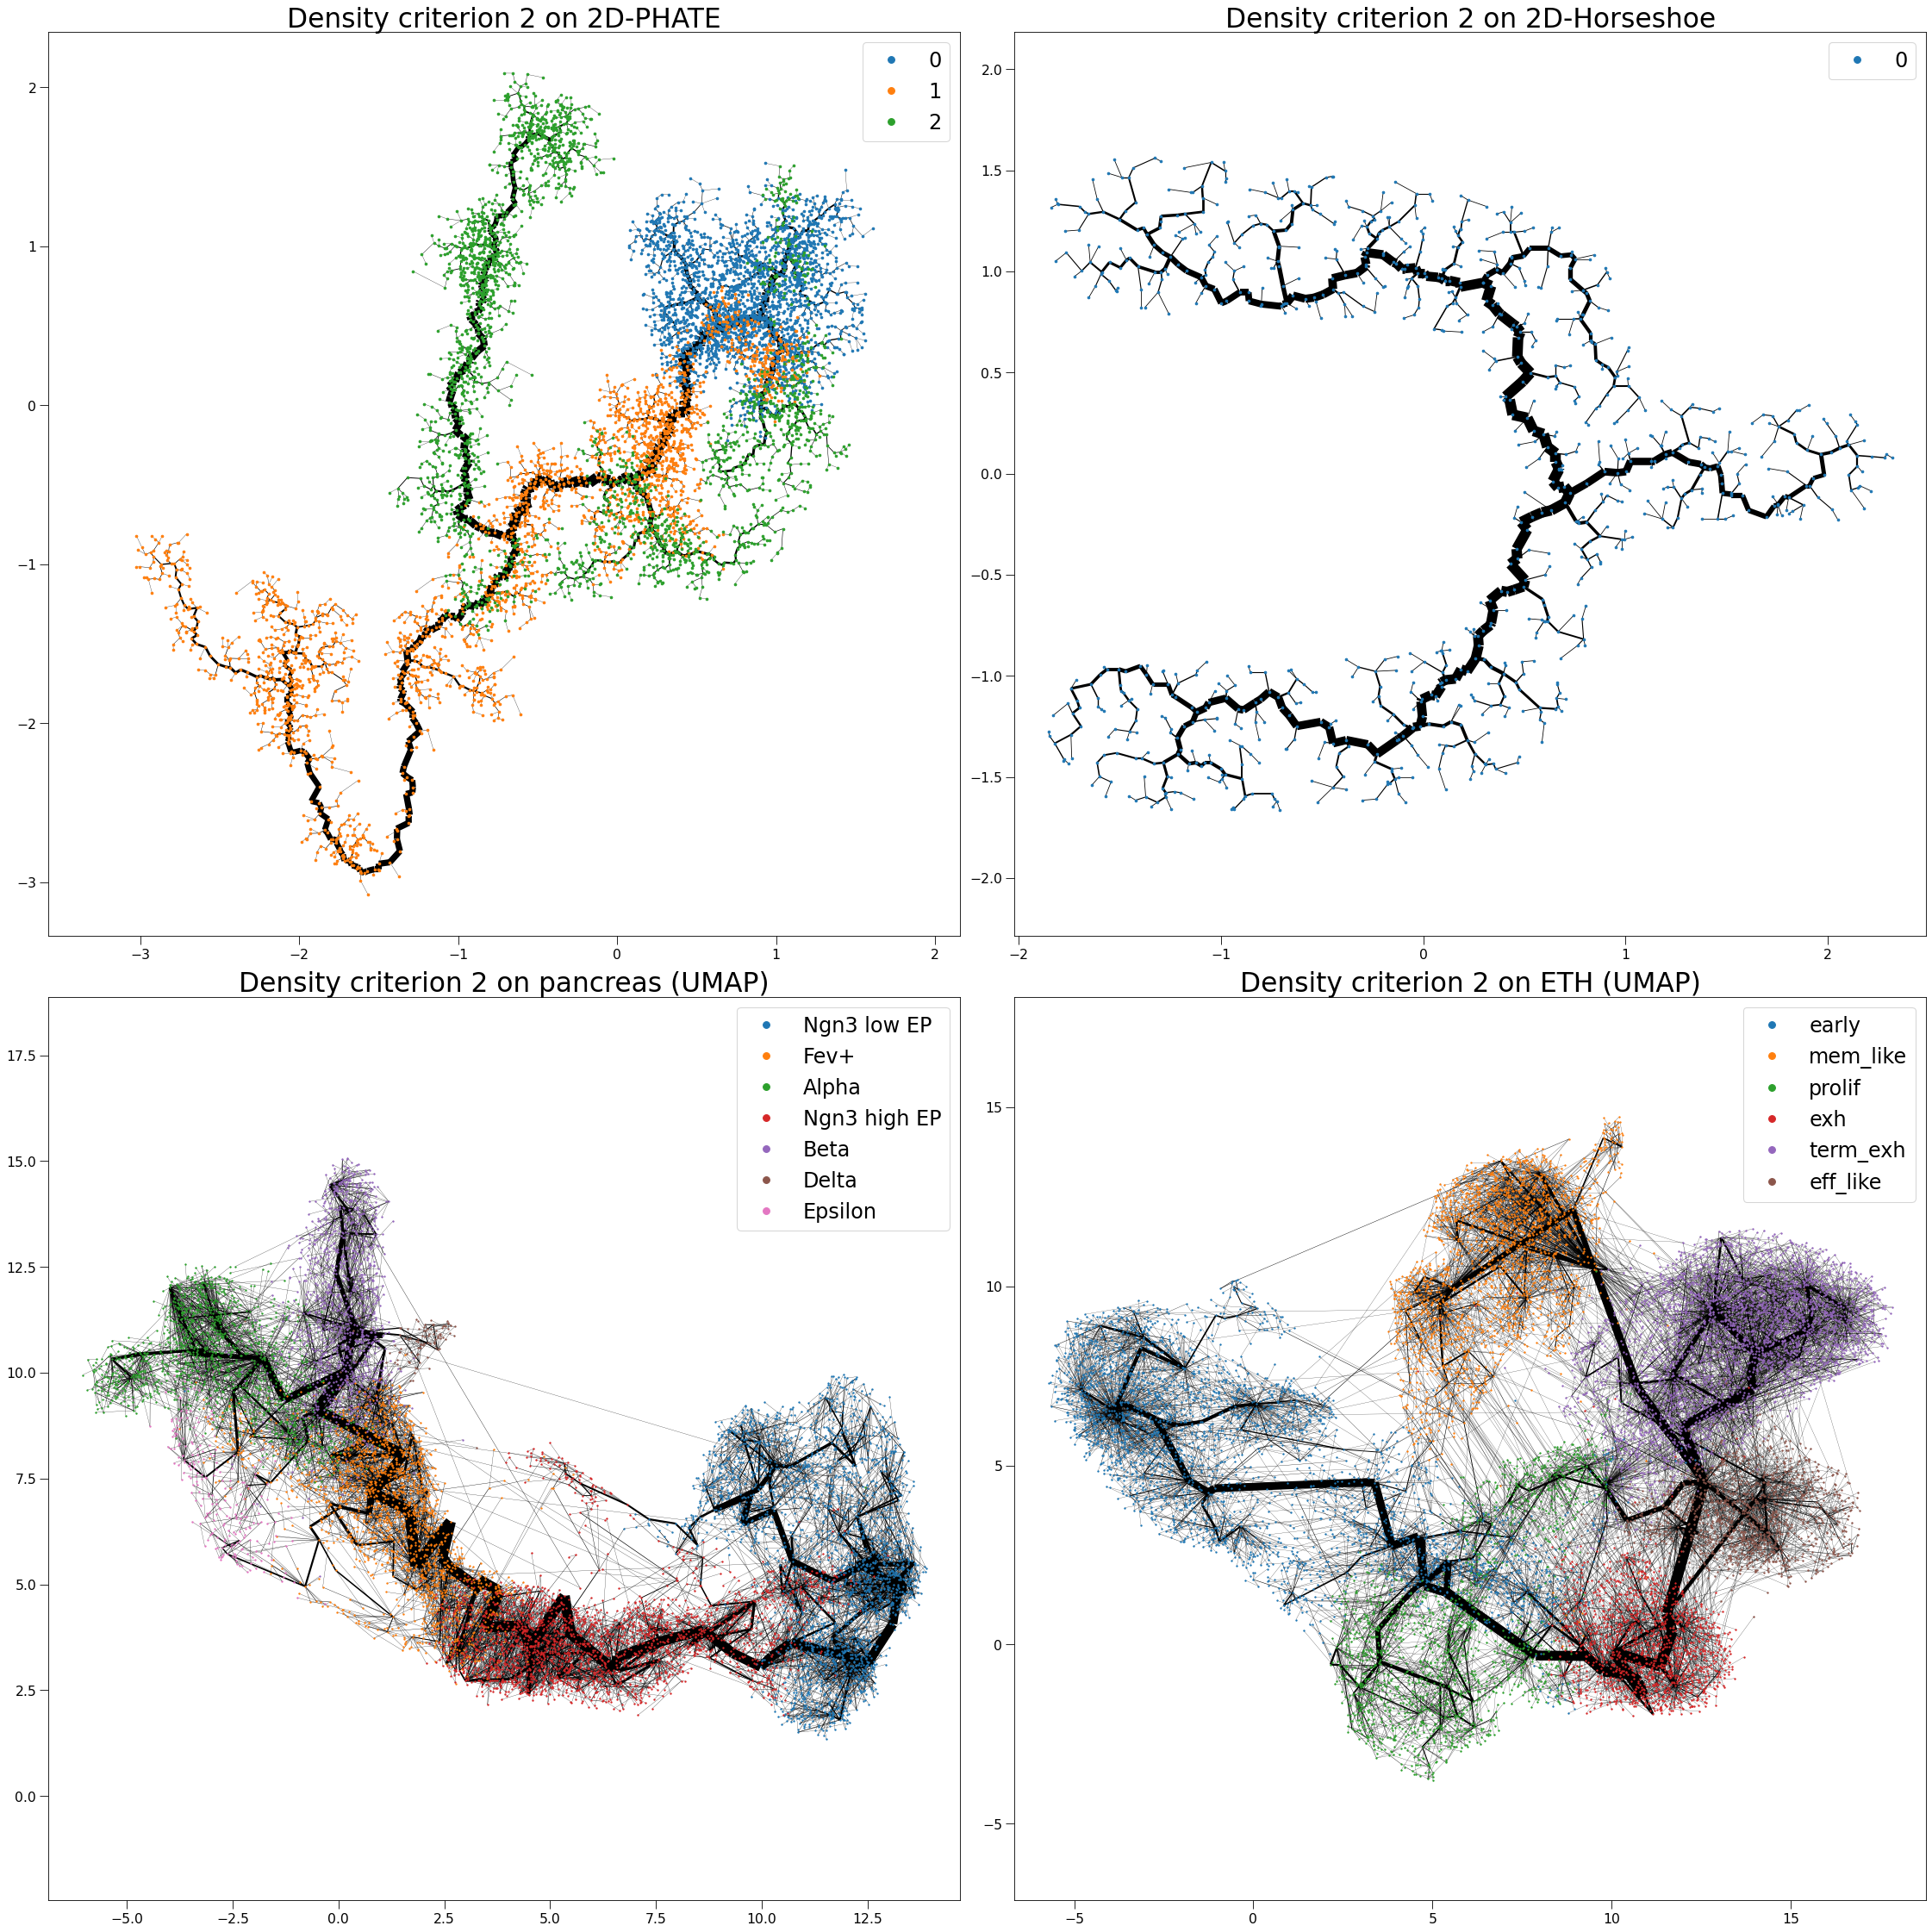

In [22]:
fig, ax = plt.subplots(2,2, figsize=(30, 30))
plot_points(position_phate, "", ax[0,0], labels=labels_phate, node_size=5)
plot_graph(ICT_phate, position_phate, "Density criterion 2 on 2D-PHATE", ax[0,0], node_size=0)
plot_points(position_horseshoe, "", ax[0,1], node_size=5)
plot_graph(ICT_horseshoe, position_horseshoe, "Density criterion 2 on 2D-Horseshoe", ax[0,1], node_size=0)


plot_points(embedding_pancreas, "", ax[1,0], labels=labels_pancreas, node_size=2.5)
plot_graph(ICT_pancreas, embedding_pancreas, "Density criterion 2 on pancreas (UMAP)", ax[1,0], node_size=0)
plot_points(embedding_eth, "", ax[1,1], labels=labels_eth, node_size=2.5)
plot_graph(ICT_eth, embedding_eth, "Density criterion 2 on ETH (UMAP)", ax[1,1], node_size=0)
ax[0,0].legend(markerscale=3)
ax[0,1].legend(markerscale=3)
ax[1,0].legend(markerscale=6)
ax[1,1].legend(markerscale=6)

plt.tight_layout()
plt.savefig("./Output/Density_criterion_2.png")
plt.show()